In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import DistilBertModel
from torch.nn.functional import mse_loss
from scipy.stats import spearmanr, pearsonr



/vol/bitbucket/tcwong/nlp_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Trained Model

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
dev = Dataset.load_from_disk("data/dev")
dev_df = pd.DataFrame(dev)

In [4]:
class CustomBert(nn.Module):
    def __init__(self, transformer_out=range(4, 7), dropout=0.1, class_weights=None):
        super(CustomBert, self).__init__()
        # Instead of just using the output of the final hidden layer,
        # you can also pass in a range of hidden layers to concatenate their outputs
        self.transformer_out = (
            range(transformer_out, transformer_out + 1)
            if isinstance(transformer_out, int)
            else transformer_out
        )
        out_dim = len(self.transformer_out) * 768

        # Use pretrained DistilBert. Force it to use our dropout
        self.distilbert = DistilBertModel.from_pretrained(
            "distilbert-base-uncased", output_hidden_states=True
        )  # type: DistilBertModel
        # for module in self.distilbert.modules():
        #     if isinstance(module, torch.nn.Dropout):
        #         module.p = dropout

        # Then apply a dense hidden layer down to 768, and a final layer down to 1
        self.feedforward = nn.Sequential(
            nn.Linear(out_dim, 768),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(768, 1),
        )

        if class_weights is not None:
            self.class_weights = class_weights
            self.pos_weight = class_weights[1] / class_weights[0]

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)

        # Recommended pooling approach for DistilBert is to average over the hidden state sequence
        # instead of outputs.last_hidden_state[:, 0], which is used for Bert which uses [CLS] token
        pooled_output = []
        for i in self.transformer_out:
            hs = outputs.hidden_states[i]
            mask = attention_mask.unsqueeze(-1)
            hs = hs * mask
            mean_hs = hs.sum(dim=1) / mask.sum(dim=1)
            pooled_output.append(mean_hs)

        # We also concatenate the outputs of multiple layers if chosen by the user
        cat_output = torch.cat(pooled_output, dim=1)

        # Apply dense feedforward
        y = self.feedforward(cat_output).squeeze(-1)

        # Outside the Trainer, we return the predictions
        if labels is None:
            return y

        # Inside the Trainer, we also need to return the loss
        global binary_classifier
        if binary_classifier:
            loss = F.binary_cross_entropy_with_logits(
                y, labels, pos_weight=self.pos_weight
            )
        else:
            loss = mse_loss(y, labels, reduction="none")
            weights = self.class_weights[labels.long()]
            loss = loss * weights
            loss = loss.mean()
        return loss, y

    def freeze(self):
        for param in self.distilbert.parameters():
            param.requires_grad = False

    def unfreeze(self, layer=None):
        if layer is not None and layer < 0:
            return

        for name, param in self.distilbert.named_parameters():
            if layer is None or name.startswith(f"transformer.layer.{layer}"):
                param.requires_grad = True

In [5]:
# calculate the same hyperparamters for defining the model
from sklearn.utils.class_weight import compute_class_weight

train = Dataset.load_from_disk("data/train")
labels = train["labels"]
dropout = 0.1
class_weights = torch.tensor(compute_class_weight("balanced", classes=np.unique(labels), y=labels)).to(DEVICE)
transformer_out = range(4, 7)

In [6]:
model = CustomBert(dropout=dropout,
        class_weights = class_weights,
        transformer_out=transformer_out,
    ).to(DEVICE)

# load in trained parameters
checkpoint_fp = 'results/model.pth'
checkpoint = torch.load(checkpoint_fp)
model.load_state_dict(checkpoint)
model.eval()

CustomBert(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear

In [7]:
def accuracy_by_group(group_df):
    n_correct_pred = 0
    atten_masks = torch.LongTensor([ls for ls in group_df.attention_mask.values])
    input_ids = torch.LongTensor([ls for ls in group_df.input_ids.values])
    completed_batches = 0
    while completed_batches < len(atten_masks):
        batch_atten_masks = atten_masks[completed_batches:completed_batches+BATCH_SIZE].to(DEVICE)
        batch_input_ids = input_ids[completed_batches:completed_batches+BATCH_SIZE].to(DEVICE)
        predictions = model(batch_input_ids, batch_atten_masks).to('cpu').detach().numpy() > 1.5
        n_correct_pred += np.sum(predictions == group_df['pcl'][completed_batches:completed_batches+BATCH_SIZE])
        completed_batches += BATCH_SIZE
    return n_correct_pred / len(group_df) if len(group_df) > 0 else -0.1
    

# Model Performance by the Degree of PCL (Question 3a)

In [8]:
# generate predictions and evaluate performance based on the degree of pcl
pcl_levels = dev_df['labels'].unique()

accuracy_by_pcl_level = []
for pcl_level in pcl_levels:
    dev_df_subset = dev_df[dev_df['labels'] == pcl_level]
    accuracy = accuracy_by_group(dev_df_subset)
    accuracy_by_pcl_level.append(accuracy)



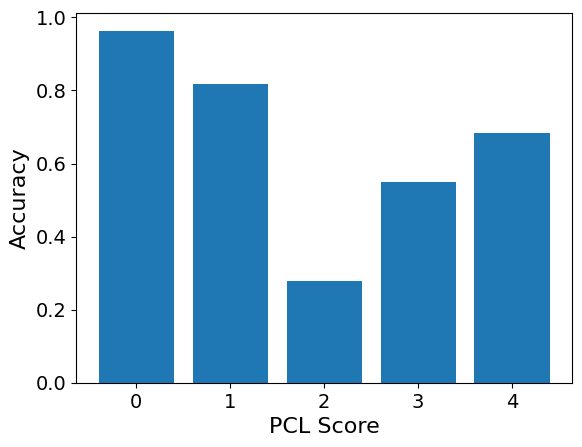

In [20]:

plt.bar(pcl_levels, accuracy_by_pcl_level)


plt.xlabel("PCL Score", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

# Model Performance by Length of Sequence (Question 3b)

In [10]:
def generate_accuracy_by_len(df):
    all_text_len = sorted(df.text.apply(len).unique())

    accuracy_by_len = []
    for text_len in all_text_len:
        dev_df_subset = df[df['text'].apply(len) == text_len]
        accuracy = accuracy_by_group(dev_df_subset)
        accuracy_by_len.append(accuracy)
    return all_text_len, accuracy_by_len

In [11]:
# generate predictions and evaluate performance based on the length of sequence
all_text_len, accuracy_by_len = generate_accuracy_by_len(dev_df)
pos_text_len, pos_accuracy_by_len = generate_accuracy_by_len(dev_df[dev_df['pcl'] == 1])
neg_text_len, neg_accuracy_by_len = generate_accuracy_by_len(dev_df[dev_df['pcl'] == 0])

In [12]:
print('Spearmans Correlation Coefficient (Monotonic Relationship):')
print(f"All Samples: {spearmanr(all_text_len, accuracy_by_len)}")
print(f"Positive Samples: {spearmanr(pos_text_len, pos_accuracy_by_len)}")
print(f"Negative Samples: {spearmanr(neg_text_len, neg_accuracy_by_len)}")

Spearmans Correlation Coefficient (Monotonic Relationship):
All Samples: SignificanceResult(statistic=0.08256188031473803, pvalue=0.055642802484877574)
Positive Samples: SignificanceResult(statistic=-0.14660417740577614, pvalue=0.06266110229200168)
Negative Samples: SignificanceResult(statistic=0.1262064961331332, pvalue=0.0038413753138027687)


In [13]:
print('Pearsons Correlation Coefficient (Linear Relationship):')
print(f"All Samples: {pearsonr(all_text_len, accuracy_by_len)}")
print(f"Positive Samples: {pearsonr(pos_text_len, pos_accuracy_by_len)}")
print(f"Negative Samples: {pearsonr(neg_text_len, neg_accuracy_by_len)}")

Pearsons Correlation Coefficient (Linear Relationship):
All Samples: PearsonRResult(statistic=-0.01663435791619291, pvalue=0.7002668417938429)
Positive Samples: PearsonRResult(statistic=-0.10218465413411097, pvalue=0.19569417044818105)
Negative Samples: PearsonRResult(statistic=0.04550470532890565, pvalue=0.29894239725303023)


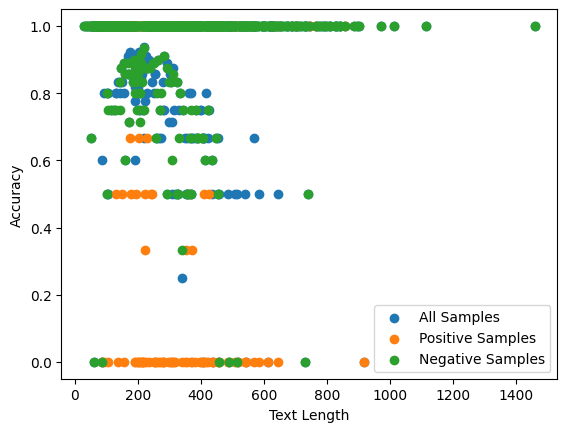

In [14]:
plt.scatter(all_text_len, accuracy_by_len, label='All Samples')
plt.scatter(pos_text_len, pos_accuracy_by_len, label='Positive Samples')
plt.scatter(neg_text_len, neg_accuracy_by_len, label='Negative Samples')

plt.xlabel("Text Length")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [15]:
# generate predictions and evaluate performance based on the length of sequence condition on degree of PCL
text_len_dict = {}
accuracy_by_len_dict = {}
for pcl_lvl in range(5):
    text_len_dict[pcl_lvl], accuracy_by_len_dict[pcl_lvl] = generate_accuracy_by_len(dev_df[dev_df['labels'] == pcl_lvl])

In [16]:
print('Pearsons Correlation Coefficient (Linear Relationship):')
for pcl_lvl in range(5):
    print(f"PCL Level {pcl_lvl} Samples: {spearmanr(text_len_dict[pcl_lvl], accuracy_by_len_dict[pcl_lvl])}")

Pearsons Correlation Coefficient (Linear Relationship):
PCL Level 0 Samples: SignificanceResult(statistic=0.0726898346628587, pvalue=0.10276126781150395)
PCL Level 1 Samples: SignificanceResult(statistic=0.11883170032633521, pvalue=0.14889956309091493)
PCL Level 2 Samples: SignificanceResult(statistic=-0.07312724241271305, pvalue=0.7878211152427433)
PCL Level 3 Samples: SignificanceResult(statistic=-0.20150038994546132, pvalue=0.06442137165905738)
PCL Level 4 Samples: SignificanceResult(statistic=-0.14793671173774092, pvalue=0.1847174059407381)


In [17]:
print('Spearmans Correlation Coefficient (Monotonic Relationship):')
for pcl_lvl in range(5):
    print(f"PCL Level {pcl_lvl} Samples: {pearsonr(text_len_dict[pcl_lvl], accuracy_by_len_dict[pcl_lvl])}")

Spearmans Correlation Coefficient (Monotonic Relationship):
PCL Level 0 Samples: PearsonRResult(statistic=0.03098816672671467, pvalue=0.48717209140916984)
PCL Level 1 Samples: PearsonRResult(statistic=0.12448072172597013, pvalue=0.13038801798397354)
PCL Level 2 Samples: PearsonRResult(statistic=0.0018480492136785376, pvalue=0.9945804161315404)
PCL Level 3 Samples: PearsonRResult(statistic=-0.18311632703966108, pvalue=0.09345093724140918)
PCL Level 4 Samples: PearsonRResult(statistic=-0.09715618537685095, pvalue=0.38520987103992765)


## Investigate Correlation between prediction and length of text

In [18]:
def pos_prediction_rate_by_group(group_df):
    n_pos_prediction = 0
    atten_masks = torch.LongTensor([ls for ls in group_df.attention_mask.values]).to(DEVICE)
    input_ids = torch.LongTensor([ls for ls in group_df.input_ids.values]).to(DEVICE)
    completed_batches = 0
    while completed_batches < len(atten_masks):
        batch_atten_masks = atten_masks[completed_batches:completed_batches+BATCH_SIZE]
        batch_input_ids = input_ids[completed_batches:completed_batches+BATCH_SIZE]
        predictions = model(batch_input_ids, batch_atten_masks).to('cpu').detach().numpy() > 1.5
        n_pos_prediction += np.sum(predictions)
        completed_batches += BATCH_SIZE
    return n_pos_prediction / len(group_df)

In [19]:
def generate_pos_prediction_rate_by_len(df):
    all_text_len = sorted(df.text.apply(len).unique())

    pos_prediction_rate_by_len = []
    for text_len in all_text_len:
        dev_df_subset = df[df['text'].apply(len) == text_len]
        pos_prediction_rate = pos_prediction_rate_by_group(dev_df_subset)
        pos_prediction_rate_by_len.append(pos_prediction_rate)
    return all_text_len, pos_prediction_rate_by_len

In [20]:
all_text_len, pos_prediction_rate_by_len = generate_pos_prediction_rate_by_len(dev_df)

In [21]:
print(pearsonr(all_text_len, pos_prediction_rate_by_len))
print(spearmanr(all_text_len, pos_prediction_rate_by_len))

PearsonRResult(statistic=0.012146069722450338, pvalue=0.7786482076821306)
SignificanceResult(statistic=-0.1279457200520872, pvalue=0.0029490070165442044)


# Model Performance by Keyword Category (Question 3c)

In [21]:
def generate_accuracy_by_keyword(df, all_keywords):
    accuracy_by_keyword = {key: 0 for key in all_keywords}
    for keyword in all_keywords:
        dev_df_subset = df[df['keyword'] == keyword]
        accuracy_by_keyword[keyword] = accuracy_by_group(dev_df_subset)
    return accuracy_by_keyword

In [22]:
# generate predictions and evaluate performance based on the keyword
all_keywords = sorted(dev_df['keyword'].unique())
accuracy_by_keyword = generate_accuracy_by_keyword(dev_df, all_keywords)
pos_accuracy_by_keyword = generate_accuracy_by_keyword(dev_df[dev_df['pcl'] == 1], all_keywords)
neg_accuracy_by_keyword = generate_accuracy_by_keyword(dev_df[dev_df['pcl'] == 0], all_keywords)


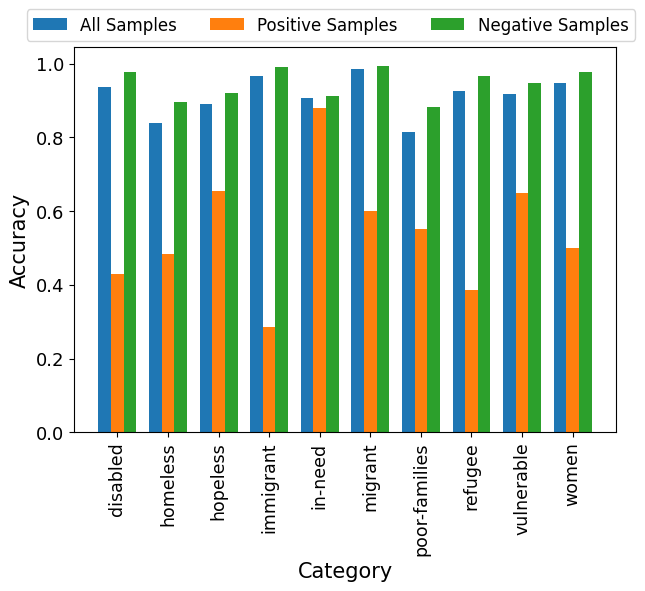

In [83]:
width = 0.25
x_axis = np.arange(len(all_keywords))

plt.figure(figsize=(7, 5))
plt.bar(x_axis, accuracy_by_keyword.values(), width=width, label='All Samples')
plt.bar(x_axis + width, pos_accuracy_by_keyword.values(), width=width, label='Positive Samples')
plt.bar(x_axis + width*2, neg_accuracy_by_keyword.values(), width=width, label='Negative Samples')

plt.xticks(x_axis+width, all_keywords, rotation=90) 
plt.legend(loc='best',
            bbox_to_anchor=(1.05, 1.12),
             ncol=3, 
            fontsize=12)

plt.xlabel("Category", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)

plt.xticks(fontsize=12.5)
plt.yticks(fontsize=13)

plt.show()

In [25]:
# Examine the variability of the test accuracy across different keywords
print(f'Standard deviation in accuracy across keywords (all samples) = {np.std(list(accuracy_by_keyword.values()))}')
print(f'Standard deviation in accuracy across keywords (positive samples) = {np.std(list(pos_accuracy_by_keyword.values()))}')
print(f'Standard deviation in accuracy across keywords (negative samples) = {np.std(list(neg_accuracy_by_keyword.values()))}')

Standard deviation in accuracy across keywords (all samples) = 0.050758106305503585
Standard deviation in accuracy across keywords (positive samples) = 0.15800873041902186
Standard deviation in accuracy across keywords (negative samples) = 0.03892424911243948


In [26]:
# generate predictions and evaluate performance based on the keyword condition on degree of PCL
accuracy_by_keyword_dict = {}
for pcl_lvl in range(5):
    accuracy_by_keyword_dict[pcl_lvl] = generate_accuracy_by_keyword(dev_df[dev_df['labels'] == pcl_lvl], all_keywords)

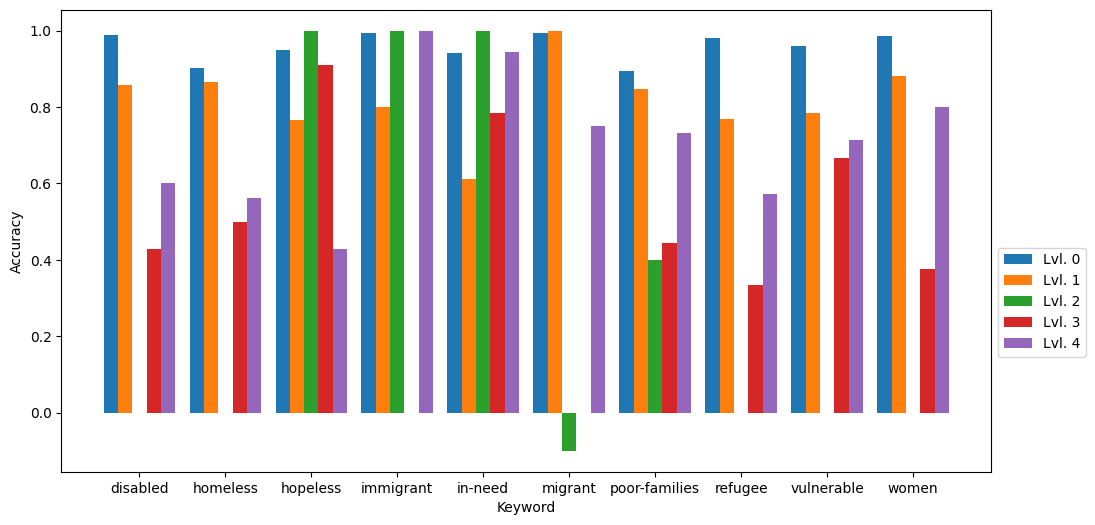

In [27]:
width = 1/6
x_axis = np.arange(len(all_keywords))

plt.figure(figsize=(12, 6))
for pcl_lvl in range(5):
    plt.bar(x_axis+width*pcl_lvl, accuracy_by_keyword_dict[pcl_lvl].values(), width=width, label=f'Lvl. {pcl_lvl}')


plt.xlabel("Keyword") 
plt.ylabel("Accuracy") 

plt.xticks(x_axis+2*width, all_keywords) 
plt.legend(bbox_to_anchor=(1, 0.5))


plt.show()